In [1]:
%matplotlib notebook

In [2]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from astroquery.mast import Catalogs
import corner
from scipy import stats
from joblib import Parallel, delayed
import multiprocessing
import os
import sys
import pickle
from astropy.stats import BoxLeastSquares
import datetime
import random
import math
import glob
import matplotlib.backends.backend_pdf

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10

In [3]:
def MAD(flux):
    med = np.median(flux)
    return np.median(np.abs(flux-med))*1.4826

def trimmed_flux(flux, time, period_test, t0_test, ndur=10): # trimmed the lightcurve near to transit
    length = 0.5*(period_test/365)**(1/3)*ndur
    bls = BoxLeastSquares(time, flux)
    transit_mask = bls.transit_mask(time, period_test, length, t0_test)
    return flux[transit_mask], time[transit_mask]

def when_transit(flux, time, period_test):
    # transit start label the start point of each transit; not the last one
    transit_start = [0]
    for i in range(len(time)-1):
        if time[i+1]-time[i] > 0.5*period_test: # find next transit
            transit_start.append(i+1)
    transit_start.append(len(time))

    # mid-transit time for each transit
    mid_transits = []
    for j in range(len(transit_start)-1):
        this_flux = flux[transit_start[j]:transit_start[j+1]]
        this_transit = time[np.argmin(this_flux)+transit_start[j]]
        mid_transits.append(this_transit)

    num_transit = len(mid_transits)
    return num_transit, mid_transits, transit_start

<IPython.core.display.Javascript object>


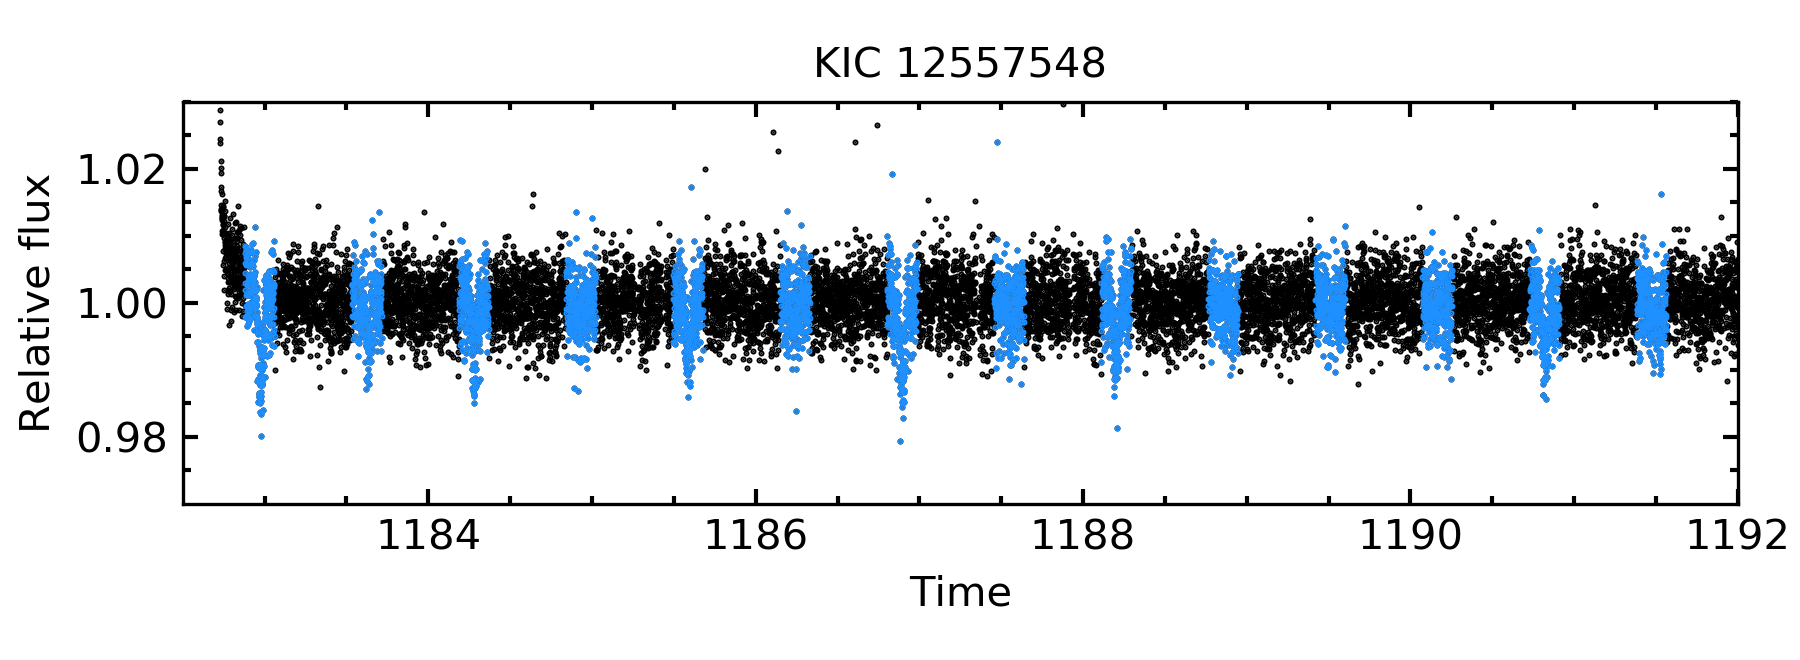

In [4]:
data = np.loadtxt('k1255_lc.dat')
all_flux = data[:,1]
all_time = data[:,0]

mean = np.median(all_flux)
std = MAD(all_flux)
period_test = 0.654
t0_test = 1182.97
depth_test = 0.02

plt.figure(figsize=(6,2.2),dpi=150)
plt.scatter(all_time, all_flux, s=0.2, c='k')
flux, time = trimmed_flux(all_flux, all_time, period_test, t0_test, ndur=3)
plt.scatter(time, flux, s=0.2, c='dodgerblue')
plt.xlabel("Time")
plt.ylabel("Relative flux")
plt.title('KIC 12557548', fontsize=10)
plt.minorticks_on()
plt.tight_layout()
plt.ylim([0.97,1.03])
plt.xlim([1182.5,1192])
plt.show()

In [5]:
flux = flux[time<1190]
time = time[time<1190]

num_transit, mid_transits, transit_start = when_transit(flux, time, period_test)
print(num_transit)
times = []
fluxs = []
for i in range(num_transit):
    times.append(time[transit_start[i]:transit_start[i+1]])
    fluxs.append(flux[transit_start[i]:transit_start[i+1]])

11


In [6]:
def asymmetric_transit_all(time, t0, period, depth,
                       pre_dur=0.04, pre_exp=0.5, post_dur=0.04, post_exp=0.5):    
    
    time = tt.as_tensor(time)
    flux = tt.ones_like(time)
    
    N = tt.round((tt.mean(time)-t0)/period)
    time -= N*period
        
    pre=((time>(t0-pre_dur))&(time<t0)).nonzero()
    flux = tt.inc_subtensor(flux[pre], depth*tt.pow(-(time[pre]-t0)/pre_dur,pre_exp)-depth)

    post=((time>t0)&(time<(t0+post_dur))).nonzero()
    flux = tt.inc_subtensor(flux[post], depth*tt.pow((time[post]-t0)/post_dur,post_exp)-depth)
    
    return flux

In [7]:
with pm.Model() as asymmetric_all:
    pre_dur = pm.Uniform('pre_dur',lower=1e-3,upper=0.1,testval=0.04)
    pre_exp = pm.Uniform('pre_exp',lower=1e-3,upper=10.,testval=0.5)
    post_dur = pm.Uniform('post_dur',lower=1e-3,upper=0.1,testval=0.04)
    post_exp = pm.Uniform('post_exp',lower=1e-3,upper=10.,testval=0.5)
    
    mid_t0 = pm.Uniform('mid_t0',lower=t0_test-0.1, upper=t0_test+0.1, testval=t0_test)
    period = pm.Uniform('period',lower=period_test-0.1, upper=period_test+0.1, testval=period_test)
    
    # hyper-depth
    mu = pm.Uniform('mu', lower=-10, upper=-0.7) # lower np.log(30*1e-6), uppper np.log(0.5*1e-6)
    sigma = pm.Uniform('sigma', lower=0, upper=5) # sigma half of the mu range
    
    # log_rpl
    log_depth = pm.Normal('log_depth',mu=mu, sigma=sigma, shape=num_transit) 
    depth = pm.Deterministic('depth', tt.sqr(tt.exp(log_depth)))
  
    for i in range(num_transit):
        pm.Normal('obs%s'%i, mu=asymmetric_transit_all(times[i],mid_t0,period,depth[i],pre_dur,pre_exp,post_dur,post_exp), 
                  sd=std, observed=fluxs[i])

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /storage/home/j/jzd52/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.10-Santiago-x86_64-3.7.4-64/tmp5va96m5l/key.pkl
INFO (theano.gof.compilelock): Waiting for existing lock by process '38287' (I am process '36792')
INFO (theano.gof.compilelock): To manually release the lock, delete /storage/home/j/jzd52/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.10-Santiago-x86_64-3.7.4-64/lock_dir


In [8]:
map_params = pm.find_MAP(model=asymmetric_all)
display(map_params)

/storage/home/jzd52/.conda/envs/WaLEs/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 11,700, ||grad|| = 2.4137e+07: : 5001it [00:14, 356.71it/s]                        



{'pre_dur_interval__': array(0.58455589),
 'pre_exp_interval__': array(-0.61071382),
 'post_dur_interval__': array(1.23424738),
 'post_exp_interval__': array(0.27139305),
 'mid_t0_interval__': array(-0.17210082),
 'period_interval__': array(-8.11252777),
 'mu_interval__': array(0.79664431),
 'sigma_interval__': array(-19.34746952),
 'log_depth': array([-3.58991726, -3.58991726, -3.58991726, -3.58991726, -3.58991726,
        -3.58991726, -3.58991726, -3.58991726, -3.58991726, -3.58991726,
        -3.58991726]),
 'pre_dur': array(0.06456939),
 'pre_exp': array(3.51961193),
 'post_dur': array(0.07768155),
 'post_exp': array(5.67478122),
 'mid_t0': array(1182.96141614),
 'period': array(0.55405993),
 'mu': array(-3.58991726),
 'sigma': array(1.97911372e-08),
 'depth': array([0.00076179, 0.00076179, 0.00076179, 0.00076179, 0.00076179,
        0.00076179, 0.00076179, 0.00076179, 0.00076179, 0.00076179,
        0.00076179])}

In [9]:
with asymmetric_all:
    trace = pm.sample(tune=5000,draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_depth, sigma, mu, period, mid_t0, post_exp, post_dur, pre_exp, pre_dur]
Sampling 4 chains: 100%|██████████| 32000/32000 [24:42<00:00, 21.59draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [10]:
pm.save_trace(trace, 'hierarchical.trace') 

'hierarchical.trace'

In [8]:
with asymmetric_all:
    trace = pm.load_trace('hierarchical.trace')

<IPython.core.display.Javascript object>


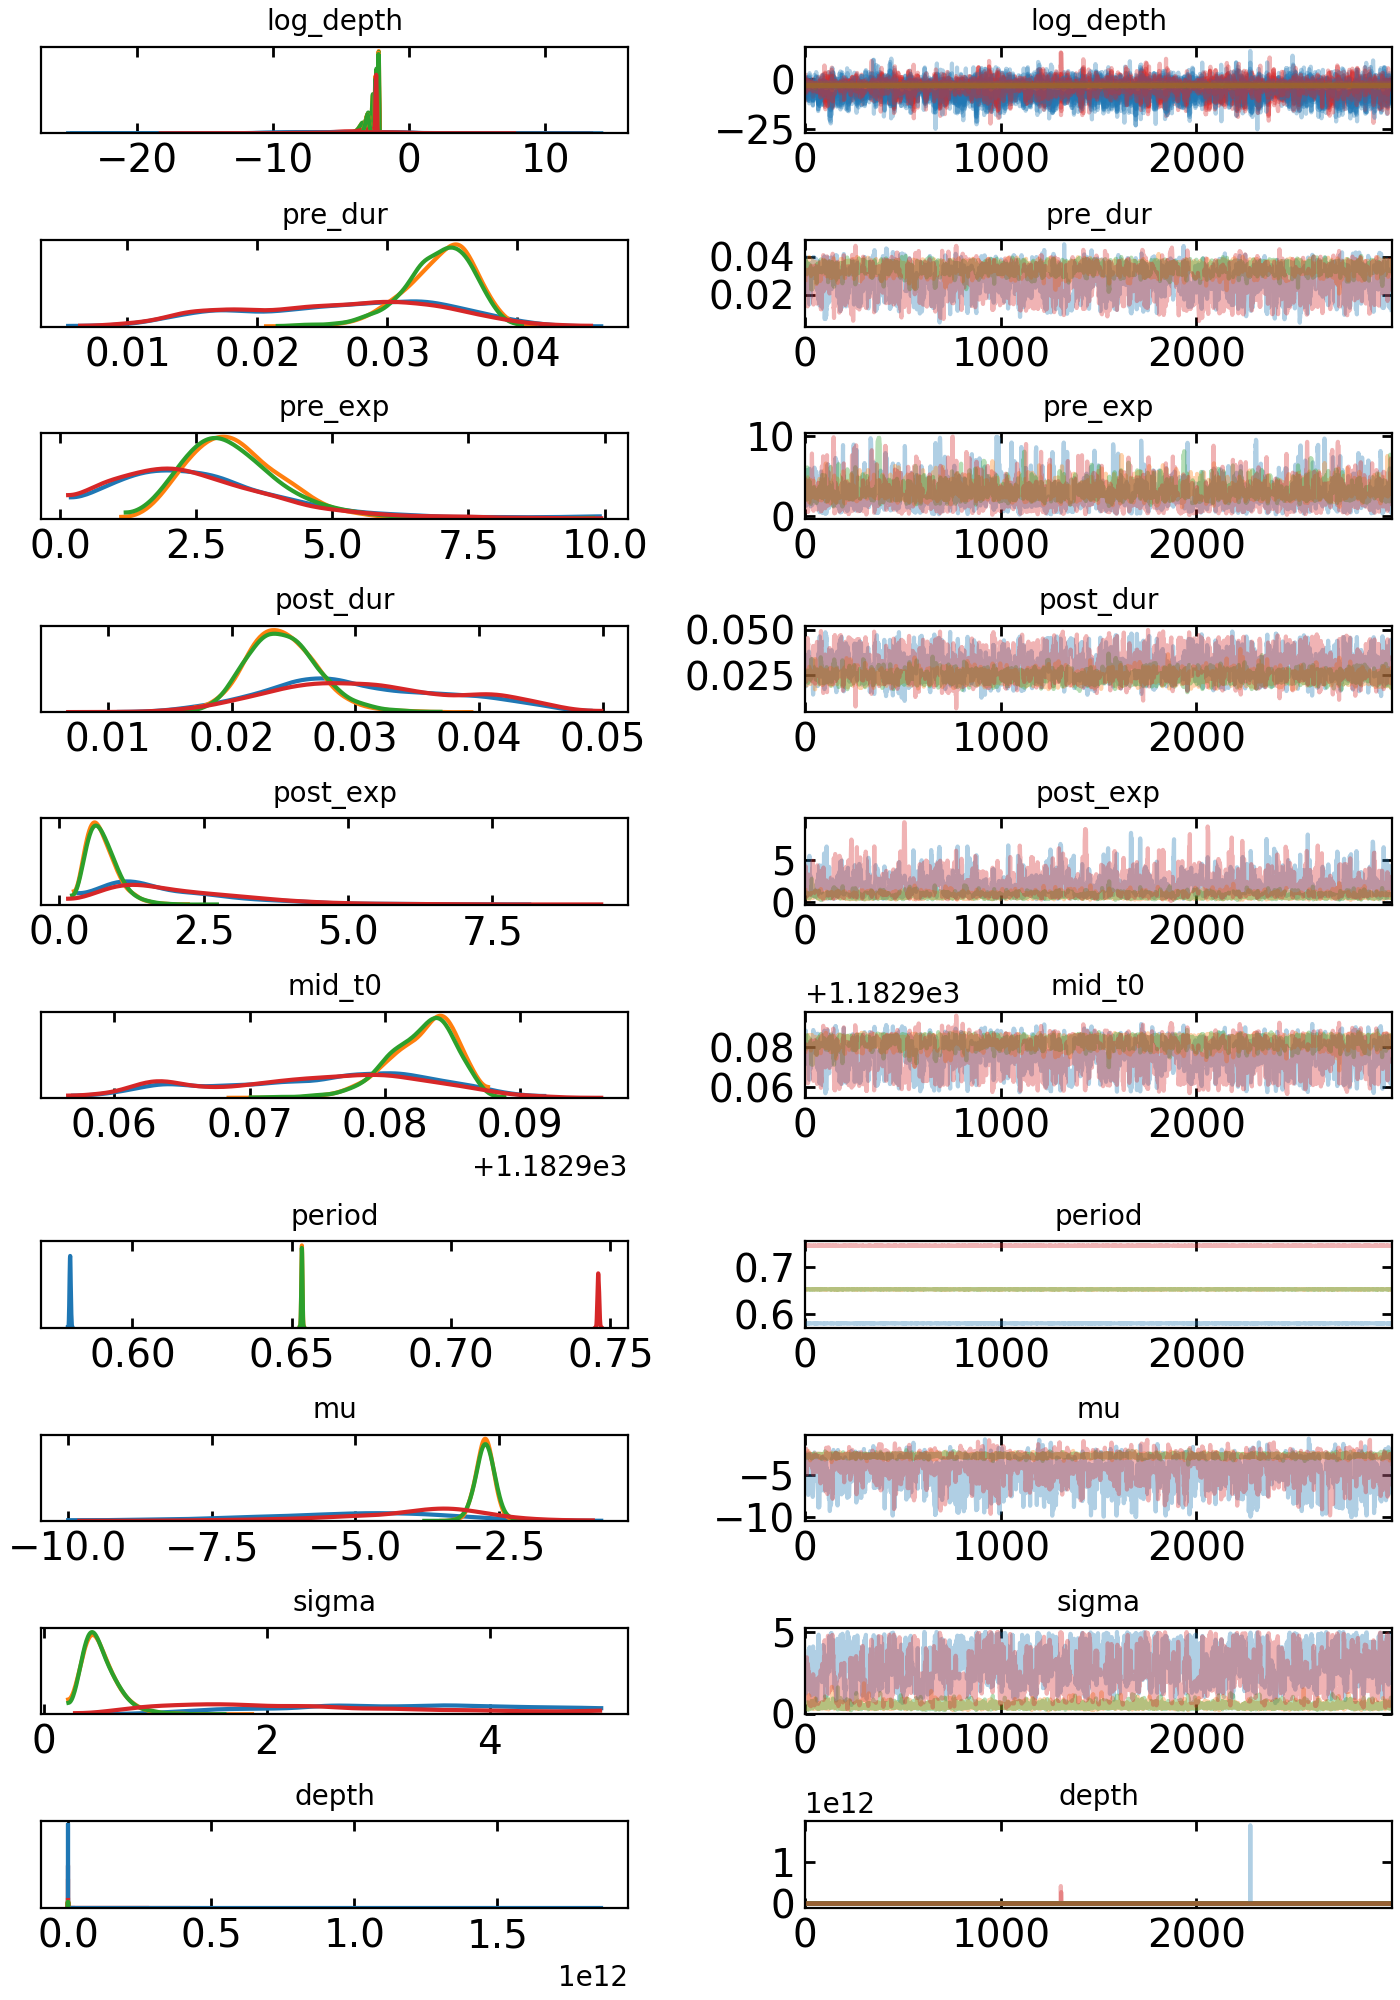

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b393cc6eed0>,
      dtype=object)

In [9]:
pm.traceplot(trace, figsize=(7,10),compact=True)

<IPython.core.display.Javascript object>


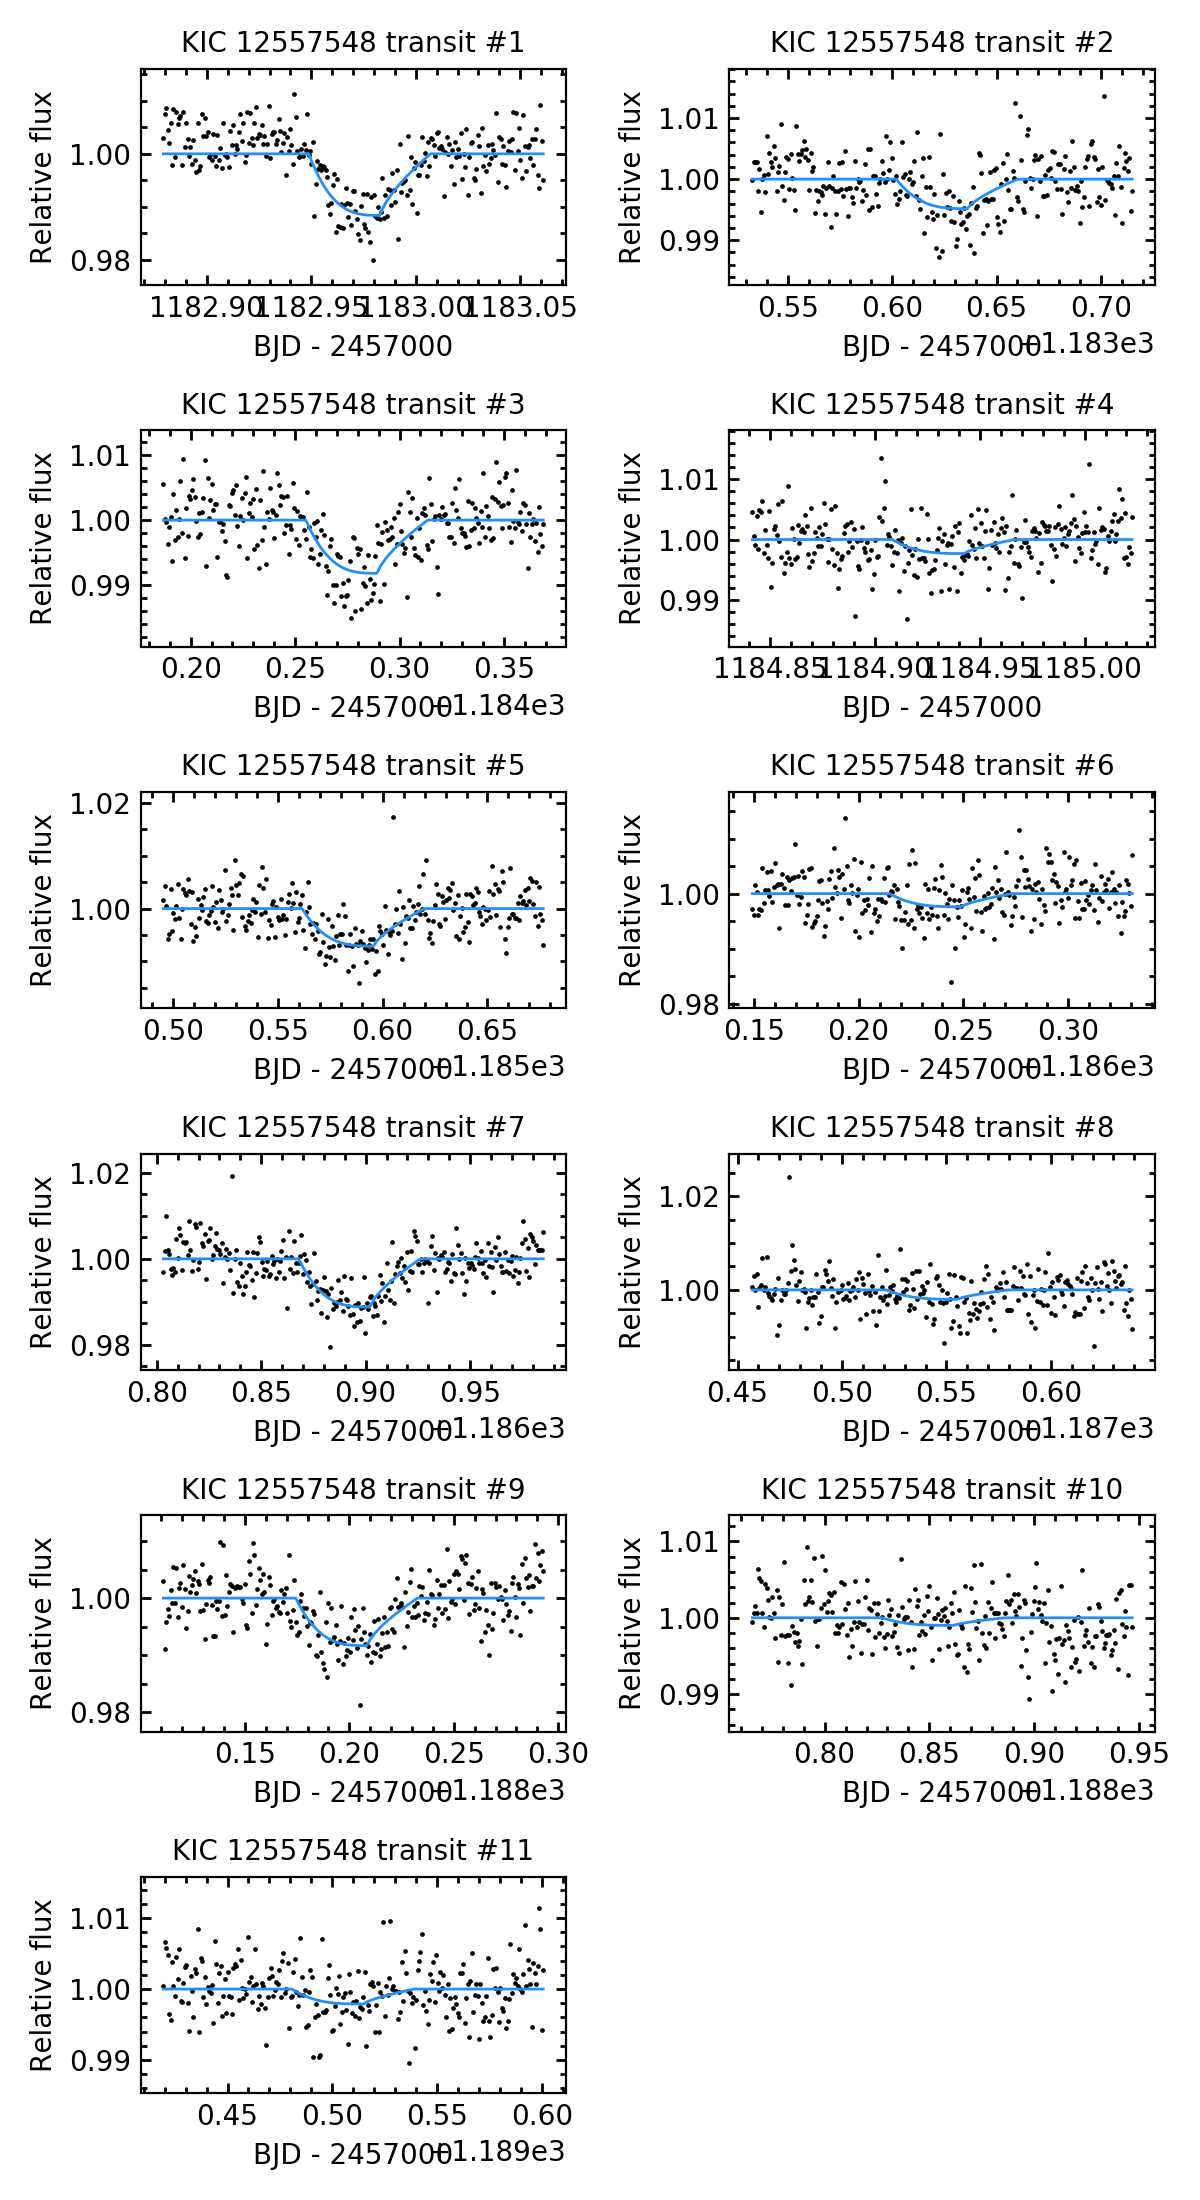

In [37]:
trace_t0 = np.median(trace['mid_t0'][3000:9000])
trace_period = np.median(trace['period'][3000:9000])
trace_depth = np.median(trace['depth'][3000:9000,:],axis=0)
trace_pre_dur = np.median(trace['pre_dur'][3000:9000])
trace_pre_exp = np.median(trace['pre_exp'][3000:9000])
trace_post_dur = np.median(trace['post_dur'][3000:9000])
trace_post_exp = np.median(trace['post_exp'][3000:9000])

plt.figure(figsize=(6,num_transit),dpi=100)
for i in range(num_transit):
    plt.subplot(math.ceil(num_transit/2),2,i+1)
    plt.scatter(times[i], fluxs[i], s=0.5, c='k')
    plt.plot(times[i],asymmetric_transit_all(times[i], t0=trace_t0, period=trace_period, depth=trace_depth[i],
                       pre_dur=trace_pre_dur, pre_exp=trace_pre_exp,
                       post_dur=trace_post_dur, post_exp=trace_post_exp).eval(),lw=1,c='dodgerblue')
    plt.xlabel("BJD - 2457000")
    plt.ylabel("Relative flux")
    plt.title('KIC 12557548 transit #%d'%(i+1), fontsize=10)
    plt.minorticks_on()
plt.tight_layout()
plt.show()
plt.savefig('transits.png',dpi=300)

<IPython.core.display.Javascript object>


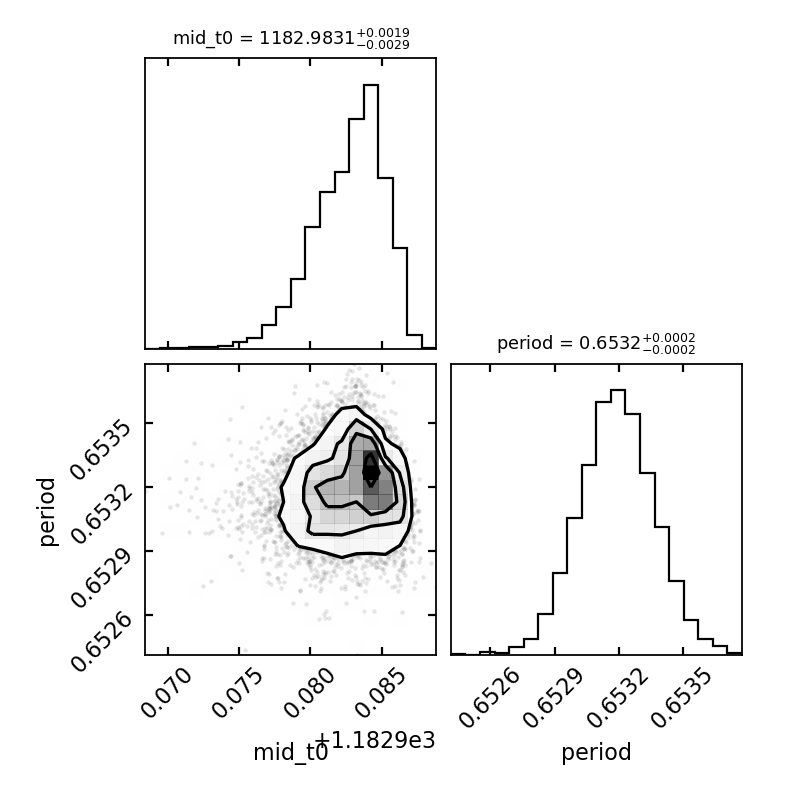

In [29]:
varnames = ['mid_t0','period']
samples = pm.trace_to_dataframe(trace, varnames=varnames)

fig = corner.corner(samples[3000:9000],show_titles=True, title_kwargs={"fontsize": 8}, title_fmt='.4f')
fig.set_dpi(80)
fig.set_size_inches(5,5)

<IPython.core.display.Javascript object>


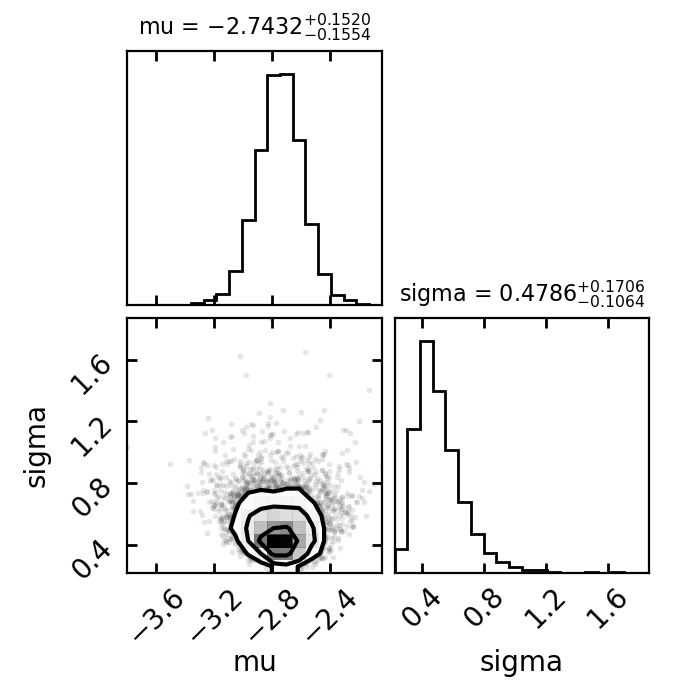

In [36]:
varnames = ['mu','sigma']
samples = pm.trace_to_dataframe(trace, varnames=varnames)

fig = corner.corner(samples[3000:9000],show_titles=True, title_kwargs={"fontsize": 8}, title_fmt='.4f')
fig.set_dpi(100)
fig.set_size_inches(3.5,3.5)
fig.savefig('depth.png',dpi=300)

<IPython.core.display.Javascript object>


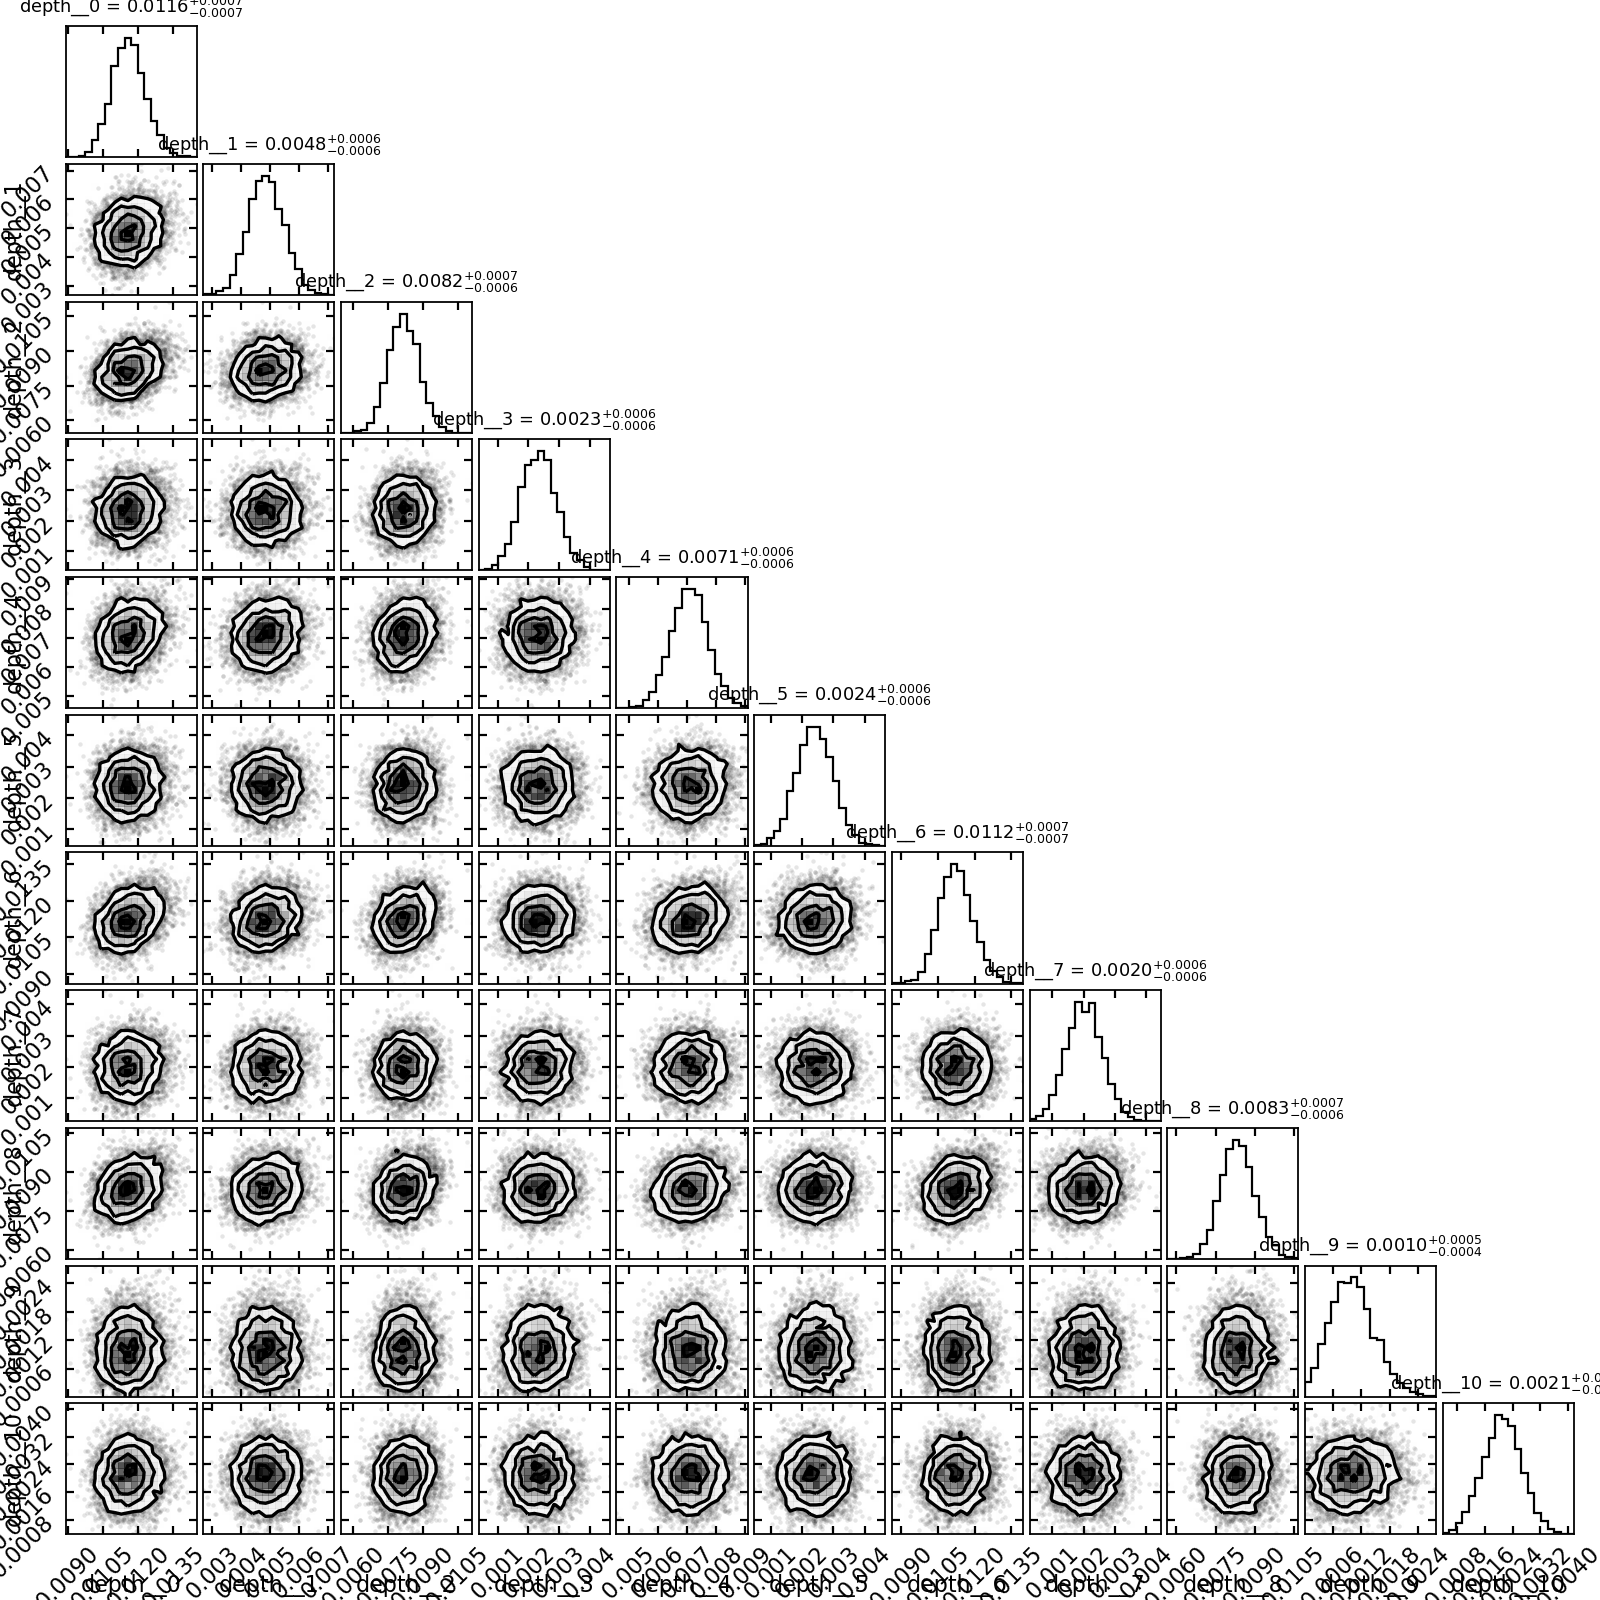

In [32]:
varnames = ['depth']
samples = pm.trace_to_dataframe(trace, varnames=varnames)

fig = corner.corner(samples[3000:9000],show_titles=True, title_kwargs={"fontsize": 8}, title_fmt='.4f')
fig.set_dpi(80)
fig.set_size_inches(10,10)